In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
import pandas
from scipy.optimize import minimize
from scipy.integrate import cumtrapz
from scipy.interpolate import UnivariateSpline

# Mean field approach for the fcc lattice

### Unit Lattice Vectors: 

$\hat{\bf a}_1=[110]/\sqrt{2},\quad$
$\hat{\bf a}_2=[1\bar{1}0]/\sqrt{2},\quad$ 

$\hat{\bf a}_3=[101]/\sqrt{2},\quad$
$\hat{\bf a}_4=[10\bar{1}]/\sqrt{2},\quad$ 

$\hat{\bf a}_5=[011]/\sqrt{2},\quad$
$\hat{\bf a}_6=[01\bar{1}]/\sqrt{2},\quad$ 

$\hat{\bf a}_{l+6}\equiv-\hat{\bf a}_{l+6}$

$
{\bf G}_{1l}\hat{\bf a}_l\equiv\hat{\bf a}_1,\quad
\Rightarrow
\quad
\hat{\bf a}_1{\bf G}_{1l} = \hat{\bf a}_l,\quad
$
$\delta{\bf b}\equiv {\bf b}-\langle{\bf b}\rangle,\quad$

---

$
V_\parallel\left(x+\langle{\rm b}_\parallel\rangle \right) = D_0\left(1-e^{-\alpha{x}}\right)^2\to 
D_0\alpha^2{x}^2
,\quad
|x|\ll1
$

---

$
\tilde{U}(\delta{\bf b})
=
    \frac{1}{2}
    \sum_{l\neq1,1+m}
    V_1\left({\bf G}_{1l}\cdot\delta{\bf b}+\langle{\bf b}\rangle \right)
    =
    \frac{1}{2}
    \sum_{l\neq1,1+m}
    V_\parallel\left(\hat{\bf a}_l\cdot\delta{\bf b}+\langle{\rm b}_\parallel\rangle\right)
    +
    \kappa D_0\alpha^2
    \left(
    |\delta{\bf b}|^2-|\hat{\bf a}_l\cdot\delta{\bf b}|^2
    \right)
    ,
$

### Bond Vectors in cylindrical coordinates with axis along ${\bf a}_1$ :

$
\delta{\bf b} = [\delta{\rm b}_\parallel,\delta{\rm b}_\perp\cos(\phi),\delta{\rm b}_\perp\sin(\phi)]
$

$
\hat{\bf a}_1 = [1,0,0] \Rightarrow 
,\quad 
\hat{\bf a}_{2-5} = [1/2,\pm\sqrt{3/8},\pm\sqrt{3/8}]
,\quad 
\hat{\bf a}_6 = [0,1,0]
$

$
\hat{\bf a}_1\cdot\delta{\bf b} = \delta{\rm b}_\parallel
,\quad
\hat{\bf a}_7\cdot\delta{\bf b} = - \hat{\bf a}_1\cdot\delta{\bf b}
$

$
\hat{\bf a}_{2-5}\cdot\delta{\bf b} = \delta{\rm b}_\parallel/2 \pm\sqrt{3/4}\delta{\rm b}_\perp\sin(\phi\pm\pi/4)
,\quad\hat{\bf a}_{8-11}\cdot\delta{\bf b} = - \hat{\bf a}_{2-5}\cdot\delta{\bf b}
$

$
\hat{\bf a}_6\cdot\delta{\bf b} = \cos(\phi){\rm b}_\perp
,\quad\hat{\bf a}_1\cdot\delta{\bf b} = - \hat{\bf a}_2\cdot\delta{\bf b}
$

# Potential Parameters

In [2]:
kb = 8.617e-5
a0 = 2.856
AL = 1.5
D = 0.1

# Morse potential and fit / solve routines

In [3]:
def boltz(fun,T):
    f = np.exp(-(fun - fun.min())/kb/T)
    return f/f.sum()

In [4]:
def morse(r):
    return D*(1.0+np.exp(-2.0*AL*(r-a0))-2.0*np.exp(-AL*(r-a0)))#D*AL*AL*(r-a0)**2#

In [5]:
def dmorse(r):
    return -2.0*AL*D*(np.exp(-2.0*AL*(r-a0))-np.exp(-AL*(r-a0)))#D*AL*AL*(r-a0)**2#

In [6]:
def ddmorse(r):
    return D*AL*AL*(2.0*np.exp(-2.0*AL*(r-a0))-np.exp(-AL*(r-a0))) # 

In [7]:
"""
Effective potential is seperable into 
longitudinal and transverse components by the observed independence 
of the parallel and perpendicular bond components
"""
def long_potential(r,am=1.0,fsc=0.0,rt=1.0,T=0.1):
    
    # x_0 = x_0, x_1 = x_0 + (r-am)
    aa = am*a0
    dr = r-aa
    dV = fsc*dr + morse(r)
    dV += 2.0*morse(aa+dr/2.0)+2.0*morse(aa-dr/2.0) + rt*(4.0*D*AL*AL)*dr**2
    V = np.exp(-dV/kb/T)
    V = -np.log(V)*kb*T
    
    return V - V.min()

In [8]:
def tran_potential(r,T=0.1,am=1.0,fsc=0.0,rt=1.0,dint=True):
    
    aa = am*a0
    tc = rt*D*AL*AL
    lc = ddmorse(aa)
    
    if dint:

        theta = np.linspace(-np.pi,np.pi,20,endpoint=True)
        c = np.cos(theta)
        su = np.sin(theta+np.pi/4.0) * np.sqrt(0.75)
        sd = np.sin(theta-np.pi/4.0) * np.sqrt(0.75)
        F = np.zeros(r.size) #

        for i in range(r.size):
            V = morse(su*r[i]+aa)+morse(sd*r[i]+aa)+morse(-su*r[i]+aa)+morse(-sd*r[i]+aa)    
            V += morse(c*r[i]+aa)/2.0+morse(-c*r[i]+aa)/2.0 
            V += tc*(3.5+c*c)*r[i]*r[i]
            II = np.exp(-V/kb/T).sum()
            F[i] += -kb*T*np.log(II.copy())
    else:
        
        F = np.zeros(r.size) #
        for theta in [0.0,np.pi/4.0,np.pi/2.0,3.0*np.pi/4.0]:
            c = np.cos(theta)
            su = np.sin(theta+np.pi/4.0) * np.sqrt(0.75)
            sd = np.sin(theta-np.pi/4.0) * np.sqrt(0.75)
            V = morse(su*r+aa)+morse(sd*r+aa)+morse(-su*r+aa)+morse(-sd*r+aa)    
            V += morse(c*r+aa)/2.0+morse(-c*r+aa)/2.0 
            F += np.exp(-V/kb/T)
        F = -kb*T*np.log(F) + tc*(3.5+c*c)*r*r
    return F-F[0]

In [9]:
"""
Determination of lambda parameter
"""
def find_linear_correction(T=0.1,nstep=10000,minr=0.1,maxr=5.0,am=1.0,rt=1.0):
        
        # base on quad value
        r = np.linspace(minr,maxr,nstep,endpoint=True)
        
        aa = am*a0
        bV = long_potential(r,am=am,fsc=0.0,rt=rt,T=T)
        bV -= bV.min()
        
        sel = bV/T/kb<200.0 
        r,bV = r[sel],bV[sel]
        
        brho = np.exp(-(bV-bV.mean())/T/kb)
        
        def f(m):
            rho = brho * np.exp(-m*(r-aa)/T/kb)
            res = np.abs(np.log( (rho*r).sum() / rho.sum() / aa)).sum()
            return res
        solver = minimize(f, [0.0], method='Nelder-Mead', tol=1e-40)
        
        return solver.x[0]

In [10]:
"""
Determination of effective temperature
'dint' option gives 100x speed up in full_tran_energy with less than 0.1meV/atom error,
leading to 3x speed up in find_T()
"""
def find_T(T=10.0,rt=0.0,am=1.0,nstep=100,dint=True):
    r = np.linspace(0.1,2.5,nstep)*a0
    def dvirialE(_T):
        res = full_tran_energy(T=_T,am=am,rt=rt,dint=dint) * 4.0
        _fsc = find_linear_correction(T=_T,nstep=nstep,am=am,rt=rt,minr=0.1*a0,maxr=2.5*a0)
        _rho = boltz(long_potential(r,am=am,fsc=_fsc,rt=rt,T=_T),_T)
        res += (_rho*dmorse(r)*(r-am*a0)).sum()*2.0
        return np.abs(np.abs(res/kb)/T-1.0)
    kcsolver = minimize(dvirialE, [T], method='Nelder-Mead', tol=1e-30)
    return kcsolver.x[0]

In [11]:
def full_tran_energy(T=0.1,am=1.0,rt=1.0,dint=True):
    r = np.linspace(0.01*a0,2.0*a0,101)
    rho = boltz(tran_potential(r,T=T,am=am,rt=rt,dint=dint)-kb*T*np.log(r),T)
    tc = rt*D*AL*AL
    return tc*(rho*r*r).sum()# / (rho*r).sum()

In [12]:
def calc_approximation(temp_array, a0, RT, am, equ):
    approx_array = np.zeros((temp_array.size,4))   
    approx_array[:,0] = temp_array
    
    r = np.linspace(0.1,3.5,10000)*a0
    
    for ii,T in enumerate(approx_array[:,0]):
        
        sT = T
        tE = full_tran_energy(T=sT,rt=RT,am=am)
        
        # uncorrelated
        lV = long_potential(r,am=am,fsc=0.0,rt=RT,T=sT) +  0.5*morse(2.0*am*a0-r)-0.5*morse(r)
        approx_array[ii][1] = ((boltz(lV,sT)*(morse(r)-morse(am*a0))).sum() + tE)*6000.0 - equ*T
        
        # correlated
        fsc = find_linear_correction(T=sT,nstep=1000,am=am,rt=RT,minr=0.1*a0,maxr=4.5*a0)   
        lV = long_potential(r,am=am,fsc=fsc,rt=RT,T=sT)
        approx_array[ii][2] = ((boltz(lV,sT)*(morse(r)-morse(am*a0))).sum() + tE)*6000.0 - equ*T
        
        # correlated + virial
        t=time.time()
        sT = find_T(T=T,am=am,rt=RT,dint=False)
        print("find_T(T_vir=",np.round(T),"1+epsilon=",am,"kappa=",RT,") : ",time.time()-t,"seconds")
        
        tE = full_tran_energy(T=sT,rt=RT,am=am)
        fsc = find_linear_correction(T=sT,nstep=1000,am=am,rt=RT,minr=0.1*a0,maxr=4.5*a0)   
        lV = long_potential(r,am=am,fsc=fsc,rt=RT,T=sT)
        approx_array[ii][3] = ((boltz(lV,sT)*(morse(r)-morse(am*a0))).sum() + tE)*6000.0 - equ*T
        
    approx_array = np.r_[approx_array]
    approx_array = approx_array[approx_array[:,0].argsort(),:]
    return approx_array

In [13]:
def analyse_md(df_sub, equ, fT):
    md_array = np.zeros((df_sub.T_vir_md_main.values.size,3))
    md_array[:,0] = df_sub.T_vir_md_main.values
    md_array[:,1] = (df_sub.V_orth_main.values+df_sub.V_para_main.values-md_array[:,0]) * equ # md
    md_array[:,2] = np.sqrt(df_sub.ensemble_error_3.values**2+df_sub.ensemble_error_4.values**2) * equ # mde
    aUs = UnivariateSpline(md_array[:,0],md_array[:,1],s=0.01) # md
    eUs = UnivariateSpline(md_array[:,0],md_array[:,2]+equ*df_sub.ensemble_error_5.values,s=0.01) # mde
    efT = UnivariateSpline(md_array[:,0],df_sub.ensemble_error_5.values,s=0.01)(fT) # T
    dF = -cumtrapz(aUs(fT),1.0/fT)*fT[1:]
    dFeu = -cumtrapz(eUs(fT-efT),1.0/(fT+efT))*(fT[1:]+efT[1:])
    dFel = -cumtrapz(eUs(fT+efT),1.0/(fT-efT))*(fT[1:]-efT[1:])
    return aUs, eUs, dF, dFeu, dFel

# Free energy evaluation

`energy_data` is a `np.array` of all simulation data, where (using slice notation)

- `energy_data[:,0]` = ${\rm T}$, target temperature
- `energy_data[:,1]` = 1+$\epsilon$, dilation
- `energy_data[:,2]` = $\kappa$, transverse strength ratio

- `energy_data[:,3]` = $\langle V_\perp\rangle$, from last half of thermalization stage
- `energy_data[:,4]` = $\langle V_\parallel\rangle$, from last half of thermalization stage
- `energy_data[:,5]` = ${\rm T}^{\rm MD}_{\rm vir}({\rm T})$ from last half of thermalization stage
- `energy_data[:,6]` = $\langle V_\perp\rangle$, during main run
- `energy_data[:,7]` = $\langle V_\parallel\rangle$, during main run
- `energy_data[:,8]` = ${\rm T}^{\rm MD}_{\rm vir}({\rm T})$ during main run

- `energy_data[:,9+n]` ensemble error in `energy_data[:,3+n]`



We use ${\rm T}^{\rm MD}_{\rm vir}({\rm T})$ from the main run as the temperature for thermodynamic integration

In [14]:
dump_folder = '../MPIE_Al_JP_REAL_100k_2'
df = pandas.read_csv(os.path.join(dump_folder,"energy_data.csv"))

In [15]:
df

,Unnamed: 0,temperature,dilation,kappa,V_orth_last,V_para_last,T_vir_md_last,V_orth_main,V_para_main,T_vir_md_main,ensemble_error_0,ensemble_error_1,ensemble_error_2,ensemble_error_3,ensemble_error_4,ensemble_error_5
0,0,100.0,1.00,0.0,97.128506,0.000000,99.115724,97.970544,0.000000,99.973774,0.187059,0.000000,0.197145,0.277500,0.000000,0.283450
1,1,200.0,1.00,0.0,190.451820,0.000000,198.256271,192.052760,0.000000,199.921946,0.354167,0.000000,0.388423,0.541858,0.000000,0.568194
2,2,300.0,1.00,0.0,280.577601,0.000000,297.420312,282.867092,0.000000,299.850439,0.504570,0.000000,0.572458,0.790366,0.000000,0.849730
3,3,400.0,1.00,0.0,367.974818,0.000000,396.604952,370.893617,0.000000,399.762198,0.641510,0.000000,0.749480,1.024158,0.000000,1.127003
4,4,500.0,1.00,0.0,453.012459,0.000000,495.807384,456.510506,0.000000,499.659202,0.767522,0.000000,0.920009,1.244827,0.000000,1.399717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,600.0,1.04,1.0,143.671673,443.645953,597.098421,143.942410,444.582775,598.317571,0.242625,0.315272,0.583199,0.168744,0.635902,0.715764
96,96,700.0,1.04,1.0,168.325415,514.631716,696.609869,168.639187,515.714196,698.023927,0.282527,0.359228,0.676294,0.195827,0.738634,0.833314
97,97,800.0,1.04,1.0,193.156089,584.855932,796.119726,193.512418,586.081264,797.726516,0.322179,0.401345,0.768325,0.222626,0.840178,0.950156
98,98,900.0,1.04,1.0,218.155766,654.345126,895.627926,218.554195,655.710606,897.425342,0.361566,0.441785,0.859327,0.249141,0.940533,1.066265


In [16]:
myc = {}
myc['r'] = (1.0,0.0,44./255.)
myc['b'] = (71./255.,0.0,167./255.)
myc['o'] = (1.0,180./255.,7./255.)
myc['g'] = (0.0/255.0,180./255.,7./255.)
lw=2.
labels = [r"$3{\rm k_BT}/2$","MD"+r"$\pm$"+" error","mean field (mf)","mf+corr. (mfc)","mfc+vir. (mfcv)"]

[ 99.9737738  199.92194621 299.85043912 399.76219846 499.6592018
 599.54288934 699.41435378 799.27444688 899.12384665 998.96310244]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


find_T(T_vir= 100.0 1+epsilon= 1.0 kappa= 0.0 ) :  1.3611218929290771 seconds
find_T(T_vir= 200.0 1+epsilon= 1.0 kappa= 0.0 ) :  1.426074743270874 seconds
find_T(T_vir= 300.0 1+epsilon= 1.0 kappa= 0.0 ) :  1.5054090023040771 seconds
find_T(T_vir= 400.0 1+epsilon= 1.0 kappa= 0.0 ) :  2.3175506591796875 seconds
find_T(T_vir= 500.0 1+epsilon= 1.0 kappa= 0.0 ) :  1.8350608348846436 seconds
find_T(T_vir= 600.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.7649731636047363 seconds
find_T(T_vir= 699.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.745643138885498 seconds
find_T(T_vir= 799.0 1+epsilon= 1.0 kappa= 0.0 ) :  1.147475004196167 seconds
find_T(T_vir= 899.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.8178906440734863 seconds
find_T(T_vir= 999.0 1+epsilon= 1.0 kappa= 0.0 ) :  1.3463518619537354 seconds

---- ERROR AT T=1050K---
 	F_mfcv-F_md: -0.2087 meV/atom
 	ensemble error in F_md: 1.717 meV/atom
 	ensemble error in T_vir: 0.66 K
 

[ 99.87540102 199.74391854 299.60744644 399.46620995 499.31994838
 599.16827552 699.010

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


find_T(T_vir= 100.0 1+epsilon= 1.04 kappa= 0.0 ) :  1.1005549430847168 seconds
find_T(T_vir= 200.0 1+epsilon= 1.04 kappa= 0.0 ) :  1.6202600002288818 seconds
find_T(T_vir= 300.0 1+epsilon= 1.04 kappa= 0.0 ) :  1.1728019714355469 seconds
find_T(T_vir= 399.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.9620771408081055 seconds
find_T(T_vir= 499.0 1+epsilon= 1.04 kappa= 0.0 ) :  1.5700669288635254 seconds
find_T(T_vir= 599.0 1+epsilon= 1.04 kappa= 0.0 ) :  1.1671168804168701 seconds
find_T(T_vir= 699.0 1+epsilon= 1.04 kappa= 0.0 ) :  1.1525118350982666 seconds
find_T(T_vir= 799.0 1+epsilon= 1.04 kappa= 0.0 ) :  1.431650161743164 seconds
find_T(T_vir= 899.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.7955548763275146 seconds
find_T(T_vir= 999.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.7106058597564697 seconds

---- ERROR AT T=1050K---
 	F_mfcv-F_md: -0.6819 meV/atom
 	ensemble error in F_md: 2.008 meV/atom
 	ensemble error in T_vir: 0.73 K
 

[ 99.91463462 199.81537444 299.70403957 399.58158924 499.44870302
 598.7380

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


find_T(T_vir= 100.0 1+epsilon= 1.0 kappa= 0.2 ) :  1.077685832977295 seconds
find_T(T_vir= 200.0 1+epsilon= 1.0 kappa= 0.2 ) :  1.5174882411956787 seconds
find_T(T_vir= 300.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.6915550231933594 seconds
find_T(T_vir= 400.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.7139360904693604 seconds
find_T(T_vir= 499.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.7141909599304199 seconds
find_T(T_vir= 599.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.7252311706542969 seconds
find_T(T_vir= 698.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.7488880157470703 seconds
find_T(T_vir= 798.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.7518711090087891 seconds
find_T(T_vir= 898.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.7715449333190918 seconds
find_T(T_vir= 998.0 1+epsilon= 1.0 kappa= 0.2 ) :  1.491971731185913 seconds

---- ERROR AT T=1050K---
 	F_mfcv-F_md: 1.193 meV/atom
 	ensemble error in F_md: 1.182 meV/atom
 	ensemble error in T_vir: 0.43 K
 

[ 99.88349178 199.7564807  299.62009868 399.47505097 499.32187735
 599.15451871 698.9794

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


find_T(T_vir= 100.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.7216141223907471 seconds
find_T(T_vir= 200.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.7552151679992676 seconds
find_T(T_vir= 300.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.7774887084960938 seconds
find_T(T_vir= 399.0 1+epsilon= 1.04 kappa= 0.2 ) :  1.2911388874053955 seconds
find_T(T_vir= 499.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.7064309120178223 seconds
find_T(T_vir= 599.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.7558269500732422 seconds
find_T(T_vir= 699.0 1+epsilon= 1.04 kappa= 0.2 ) :  1.5030670166015625 seconds
find_T(T_vir= 799.0 1+epsilon= 1.04 kappa= 0.2 ) :  1.3371191024780273 seconds
find_T(T_vir= 899.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.7631170749664307 seconds
find_T(T_vir= 998.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.7216901779174805 seconds

---- ERROR AT T=1050K---
 	F_mfcv-F_md: 1.015 meV/atom
 	ensemble error in F_md: 1.202 meV/atom
 	ensemble error in T_vir: 0.48 K
 

dEnergy_dFreeEnergy.pdf


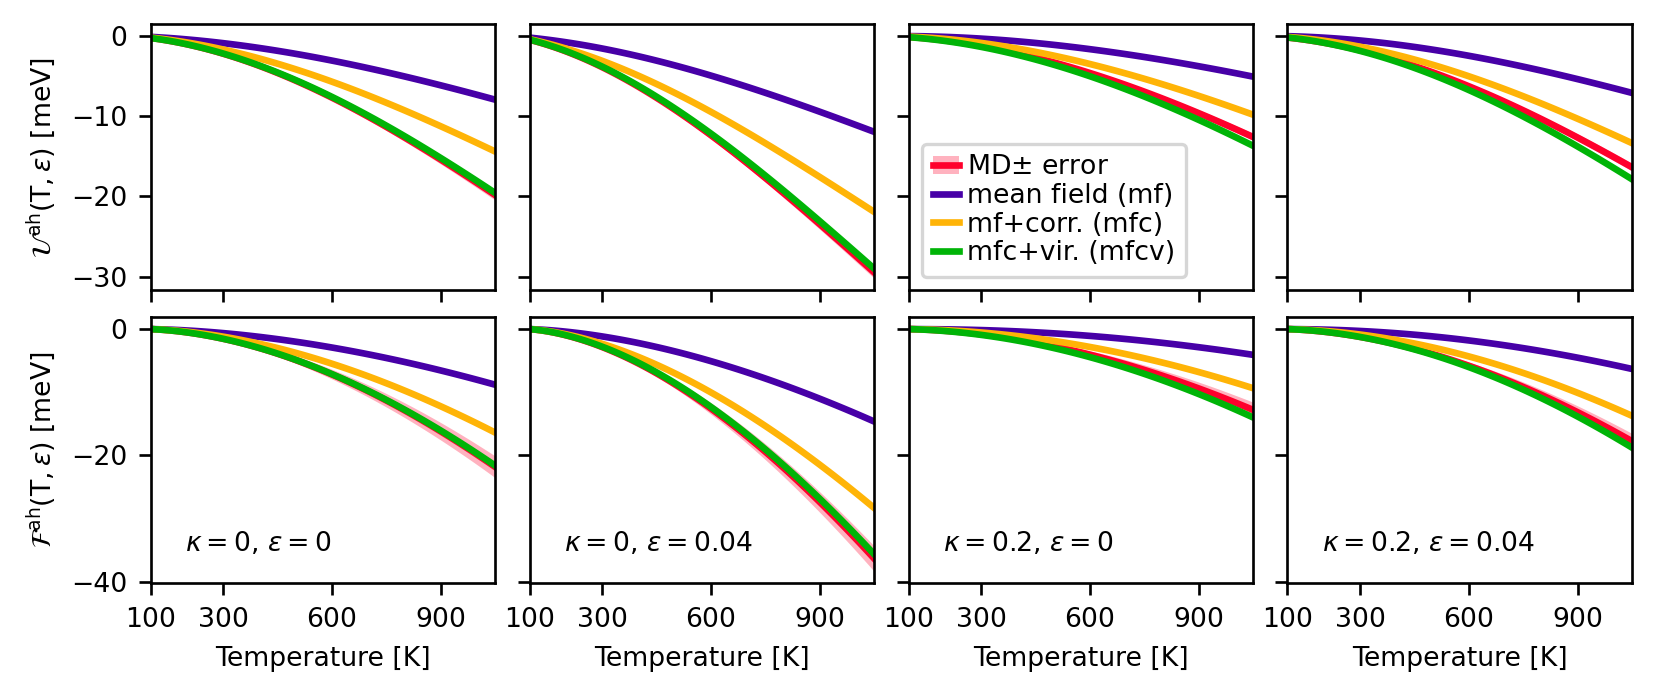

In [17]:
fig,ax=plt.subplots(2,4,figsize=(7,3),dpi=240,sharey="row",sharex="col") #, constrained_layout=True)

for epi in range(4):
    am = [1.0,1.04][epi%2]
    RT=[0.0,0.2][epi//2]
    
    # Filter data 
    df_sub = df[(df.kappa==RT) & (df.dilation==am)]
    df_sub = df_sub.sort_values("temperature")
    df_sub[df_sub.temperature >= 50.0]
    print(df_sub.T_vir_md_main.values)  
    
    equ = 1000.*kb*1.5
    
    # fine grained temperature array for integration
    fT = np.linspace(100.0,1050.0,101)
    
    # Analyse MD data 
    aUs, eUs, dF, dFeu, dFel = analyse_md(
        df_sub=df_sub, 
        equ=equ, 
        fT=fT
    )

    # Plot MD data 
    mde = ax[0,epi].fill_between(fT,y1=aUs(fT)-eUs(fT),y2=aUs(fT)+eUs(fT),facecolor=myc['r'],alpha=0.3,lw=0)
    mdp = ax[0,epi].plot(fT,aUs(fT),'-',c=myc['r'],lw=lw)
    fe = ax[1,epi].fill_between(fT[1:],y1=dF-dFel,y2=dF+dFeu,facecolor=myc['r'],alpha=0.3,lw=0)
    fp = ax[1,epi].plot(fT[1:],dF,'-',c=myc['r'],lw=lw)
    
    rF = -dF[-1]
    
    # Anharmonic approximation 
    approx_array = calc_approximation(
        temp_array=df_sub.T_vir_md_main.values, 
        a0=a0, 
        RT=RT, 
        am=am, 
        equ=equ
    )
    
    # uncorrelated
    # aUs = UnivariateSpline(Ua[:,0],Ua[:,1],s=0.01)
    aUs = UnivariateSpline(approx_array[:,0],approx_array[:,1],s=0.01)
    ucmf = ax[0,epi].plot(fT,aUs(fT),'-',c=myc['b'],lw=lw)
    dF = -cumtrapz(aUs(fT),1.0/fT)*fT[1:]
    ucmff = ax[1,epi].plot(fT[1:],dF,'-',c=myc['b'],lw=lw)
        
    # correlated
    # aUs = UnivariateSpline(Ua[:,0],Ua[:,2],s=0.01) 
    aUs = UnivariateSpline(approx_array[:,0],approx_array[:,2],s=0.01)
    cmf = ax[0,epi].plot(fT,aUs(fT),'-',c=myc['o'],lw=lw)
    dF = -cumtrapz(aUs(fT),1.0/fT)*fT[1:]
    cmff = ax[1,epi].plot(fT[1:],dF,'-',c=myc['o'],lw=lw)
    
    # correlated + virial
    # aUs = UnivariateSpline(Ua[:,0],Ua[:,3],s=0.01)
    aUs = UnivariateSpline(approx_array[:,0],approx_array[:,3],s=0.01)
    cmfv = ax[0,epi].plot(fT,aUs(fT),'-',c=myc['g'],lw=lw)
    dF = -cumtrapz(aUs(fT),1.0/fT)*fT[1:]
    cmffv = ax[1,epi].plot(fT[1:],dF,'-',c=myc['g'],lw=lw)
    rF += dF[-1]
    

    print("\n---- ERROR AT T=%dK---\n" % fT[-1],
          "\tF_mfcv-F_md: %1.4g meV/atom\n" % (-rF),
          "\tensemble error in F_md: %1.4g meV/atom\n" % (np.abs(dFel[-1])/2.0+np.abs(dFeu[-1])/2.0),
          "\tensemble error in T_vir: %1.2g K\n" % (eUs(fT)[-1]),"\n")
    
    ax[1,epi].text(0.1,0.1,r"$\kappa=%.2g$" % RT +", "+r"$\epsilon=%.2g$" % (am-1),\
         fontsize=8,transform=ax[1,epi].transAxes,horizontalalignment='left',verticalalignment='bottom')
    
        
    
"""
Formatting for plot
"""
ax[0,2].legend([(mdp[0],mde),(ucmf[0]),(cmf[0]),(cmfv[0]),],labels[1:5],
        fontsize=8,labelspacing=0.1,handlelength=1.,handletextpad=0.3,loc="lower left")
ax[0,0].set_ylabel(r"$\mathcal{U}^{\rm ah}({\rm T},\epsilon)$ [meV]",fontsize=8)
ax[1,0].set_ylabel(r"$\mathcal{F}^{\rm ah}({\rm T},\epsilon)$ [meV]",fontsize=8)

for i in range(4):
    for j in range(2):    
        ax[j,i].set_xlim(100.0,1050.0)
        ax[j,i].tick_params(axis="x", labelsize=8)
        ax[j,i].tick_params(axis="y", labelsize=8)
        ax[j,i].set_xticks([100.0,300.0,600.0,900.0])
        
    ax[1,i].set_xlabel("Temperature [K]",fontsize=8)
    

plt.tight_layout()

plt.subplots_adjust(hspace=0.1,wspace=0.1)

output_file="dEnergy_dFreeEnergy.pdf"
if not output_file is None:
    print(output_file)
    plt.savefig(output_file,bbox_inches = 'tight',pad_inches = 0)